In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# [HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS](https://www.kaggle.com/rohitrox/healthcare-provider-fraud-detection-analysis)

![MediCare](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT7EqGpB-UkZNUi3pcVWVX1nsaXAHzZpM5z7E37Ps71VHD9nFYK)

In [ ]:
### import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, precision_recall_curve, average_precision_score 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, IsolationForest, VotingClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline
plt.style.use('ggplot')

In [ ]:
def read_data(tp = "Train", N = 1542865627584):
    target = pd.read_csv("{}-{}.csv".format(tp.title(), N))
    pt = pd.read_csv("{}_Beneficiarydata-{}.csv".format(tp.title(), N))
    in_pt = pd.read_csv("{}_Inpatientdata-{}.csv".format(tp.title(), N))
    out_pt = pd.read_csv("{}_Outpatientdata-{}.csv".format(tp.title(), N))
    return (in_pt, out_pt, pt, target)

## Explore datasets 

In [ ]:
### Load Train data
in_pt, out_pt, asl, target = read_data()

In [ ]:
asl = asl.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'Gender': 2 }, 0)
asl = asl.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})

In [ ]:
print(asl.shape)
asl.head()

In [ ]:
print(target.shape)
target.head()

In [ ]:
plt.title("Potential Fraud Test distribution")
target.groupby( ["PotentialFraud"] ).Provider.count().plot(kind = "bar", figsize = (10,6))
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [ ]:
print(in_pt.shape)
in_pt.head()

In [ ]:
print(out_pt.shape)
out_pt.head()

## Adding features and combine datasets

- 1. Add Flag column 'WhetherDead' using DOD values to tell whether beneficiary is dead on not

In [ ]:
asl['WhetherDead']= 0
asl.loc[asl.DOD.notna(),'WhetherDead'] = 1

- 2. Adding Target numeric variable. 

In [ ]:
target["target"] = np.where(target.PotentialFraud == "Yes", 1, 0) 

- 3. Combine Inpatient and Outpatient datasets 

In [ ]:
MediCare = pd.merge(in_pt, out_pt, left_on = [ x for x in out_pt.columns if x in in_pt.columns], right_on = [ x for x in out_pt.columns if x in in_pt.columns], how = 'outer')
MediCare.shape

- 4. Add Patients information

In [ ]:
data = pd.merge(MediCare, asl,left_on='BeneID',right_on='BeneID',how='inner')
data.shape

- 5. Create a new variable "NumPhysicians" with number of physians(from 0 to 3): 'AttendingPhysician' not missing + 'OperatingPhysician' not missing +  'OtherPhysician' not missing

In [ ]:
### Check Physicians columns for stange records and value length.
def len_check(data , l):
    S = dict()
    for i in data.columns:
         S[i] = [x for x in data.loc[ np.any(data[[i]].notnull().to_numpy(), axis = 1)][i].unique() if (len(str(x)) < l | len(str(x)) > l ) ]
    
    print(S)

len_check(data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']], len('PHY388358'))  

In [ ]:
def uniq(a):
    return np.array([len(set([i for i in x[~pd.isnull(x)]])) for x in a.values])

In [ ]:
### Create new variable and drop 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician'
data['NumPhysicians'] = uniq(data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']]) 
data = data.drop(['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician'], axis = 1)

- 6. Count number of procedures 'NumProc' for each claim.

In [ ]:
ClmProcedure_vars = ['ClmProcedureCode_{}'.format(x) for x in range(1,7)]
### Create new variable 
data['NumProc'] = data[ClmProcedure_vars].notnull().to_numpy().sum(axis = 1)

In [ ]:
keep = ['BeneID', 'ClaimID', 'ClmAdmitDiagnosisCode', 'NumProc' ] + ClmProcedure_vars
### Checking if procedures is unique
print(data[keep].loc[data['NumProc'] != uniq( data[ClmProcedure_vars])])

data = data.drop(ClmProcedure_vars, axis = 1)

- 7. Count number of claims, extra reported claims and unique.

In [ ]:
ClmDiagnosisCode_vars =['ClmAdmitDiagnosisCode'] + ['ClmDiagnosisCode_{}'.format(x) for x in range(1, 11)]

### Create new variable 
data['NumClaims'] = data[ClmDiagnosisCode_vars].notnull().to_numpy().sum(axis = 1)

In [ ]:
keep = ['BeneID', 'ClaimID', 'ClmAdmitDiagnosisCode', 'NumClaims'] + ClmDiagnosisCode_vars

### Create new variable 
data['NumClaims'] = data[ClmDiagnosisCode_vars].notnull().to_numpy().sum(axis = 1)

print(data[keep].loc[data['NumClaims'] != uniq( data[ClmDiagnosisCode_vars])].head())
### if checking result of unique claims is not missing, we are going to add number of unique claims.

In [ ]:
data['NumUniqueClaims'] = uniq(data[ClmDiagnosisCode_vars])

data['ExtraClm'] = data['NumClaims'] - data['NumUniqueClaims']

data = data.drop(ClmDiagnosisCode_vars, axis = 1)
data = data.drop(['NumClaims'], axis = 1)

- 8. Convert Dates and calculate days for Claim and for Admission. Calculate patient age at time of claim. 

In [ ]:
### 
data['AdmissionDt'] = pd.to_datetime(data['AdmissionDt'] , format = '%Y-%m-%d')
data['DischargeDt'] = pd.to_datetime(data['DischargeDt'],format = '%Y-%m-%d')

data['ClaimStartDt'] = pd.to_datetime(data['ClaimStartDt'] , format = '%Y-%m-%d')
data['ClaimEndDt'] = pd.to_datetime(data['ClaimEndDt'],format = '%Y-%m-%d')

data['DOB'] = pd.to_datetime(data['DOB'] , format = '%Y-%m-%d')
data['DOD'] = pd.to_datetime(data['DOD'],format = '%Y-%m-%d')

### Number of hospitalization days
data['AdmissionDays'] = ((data['DischargeDt'] - data['AdmissionDt']).dt.days) + 1
### Number of claim days 
data['ClaimDays'] = ((data['ClaimEndDt'] - data['ClaimStartDt']).dt.days) + 1

data['Age'] = round(((data['ClaimStartDt'] - data['DOB']).dt.days + 1)/365.25)

- 9. Hospitalization flag 'Hospt'

In [ ]:
data['Hospt'] = np.where(data.DiagnosisGroupCode.notnull(), 1, 0)
data = data.drop(['DiagnosisGroupCode'], axis = 1)

In [ ]:
### Check if there were any actions after death. 
data['DeadActions'] = np.where(np.any(np.array([ data[x] > data['DOD'] for x in ['AdmissionDt', 'DischargeDt', 'ClaimStartDt', 'ClaimEndDt']]), axis = 0), 1, 0)

print(data.loc[data['DeadActions'] > 0])

### If there is no actions after death date, we will drop this variable. 
data = data.drop(['AdmissionDt', 'DeadActions', 'DischargeDt', 'ClaimStartDt', 'ClaimEndDt', 'DOD', 'DOB'], axis = 1)

## Descriptive stats

In [ ]:
data.describe(exclude = ['object'])

In [ ]:
data.shape

## Checking and impute missing records

In [ ]:
data.isnull().sum()

In [ ]:
## Fill missing results using 0
data = data.fillna(0).copy()
data.columns

## Group by provider each column

In [40]:
### Sum all results
df1 = data.groupby(['Provider'], as_index = False)[['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'RenalDiseaseIndicator', 
                                                  'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
                                                  'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 
                                                  'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                                                  'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 
                                                  'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                  'ChronicCond_stroke', 'WhetherDead', 'NumPhysicians', 
                                                  'NumProc','NumUniqueClaims', 'ExtraClm', 'AdmissionDays',
                                                  'ClaimDays', 'Hospt']].sum()
### Count number of records
df2 = data[['BeneID', 'ClaimID']].groupby(data['Provider']).nunique().reset_index()
### Calculate mean
df3 = data.groupby(['Provider'], as_index = False)[['NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
                                                    'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                                                    'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age']].mean()
### Combine all together
df = df2.merge(df1, on='Provider', how='left').merge(df3, on='Provider', how='left')
print(df.shape, target.shape)

(5410, 32) (5410, 3)


# Machine Learning for fraud detection 

In [41]:
df1 = df.merge(target, on='Provider', how='left').drop(['Provider', 'target'], axis = 1)
df2 = df.merge(target, on='Provider', how='left').drop(['Provider', 'PotentialFraud'], axis = 1)
print(df.shape, target.shape)

(5410, 32) (5410, 3)


In [ ]:
g = sns.pairplot(df1, hue = 'PotentialFraud', markers="+")
g.fig.suptitle('Plot pairwise relationships in a dataset')
plt.show()

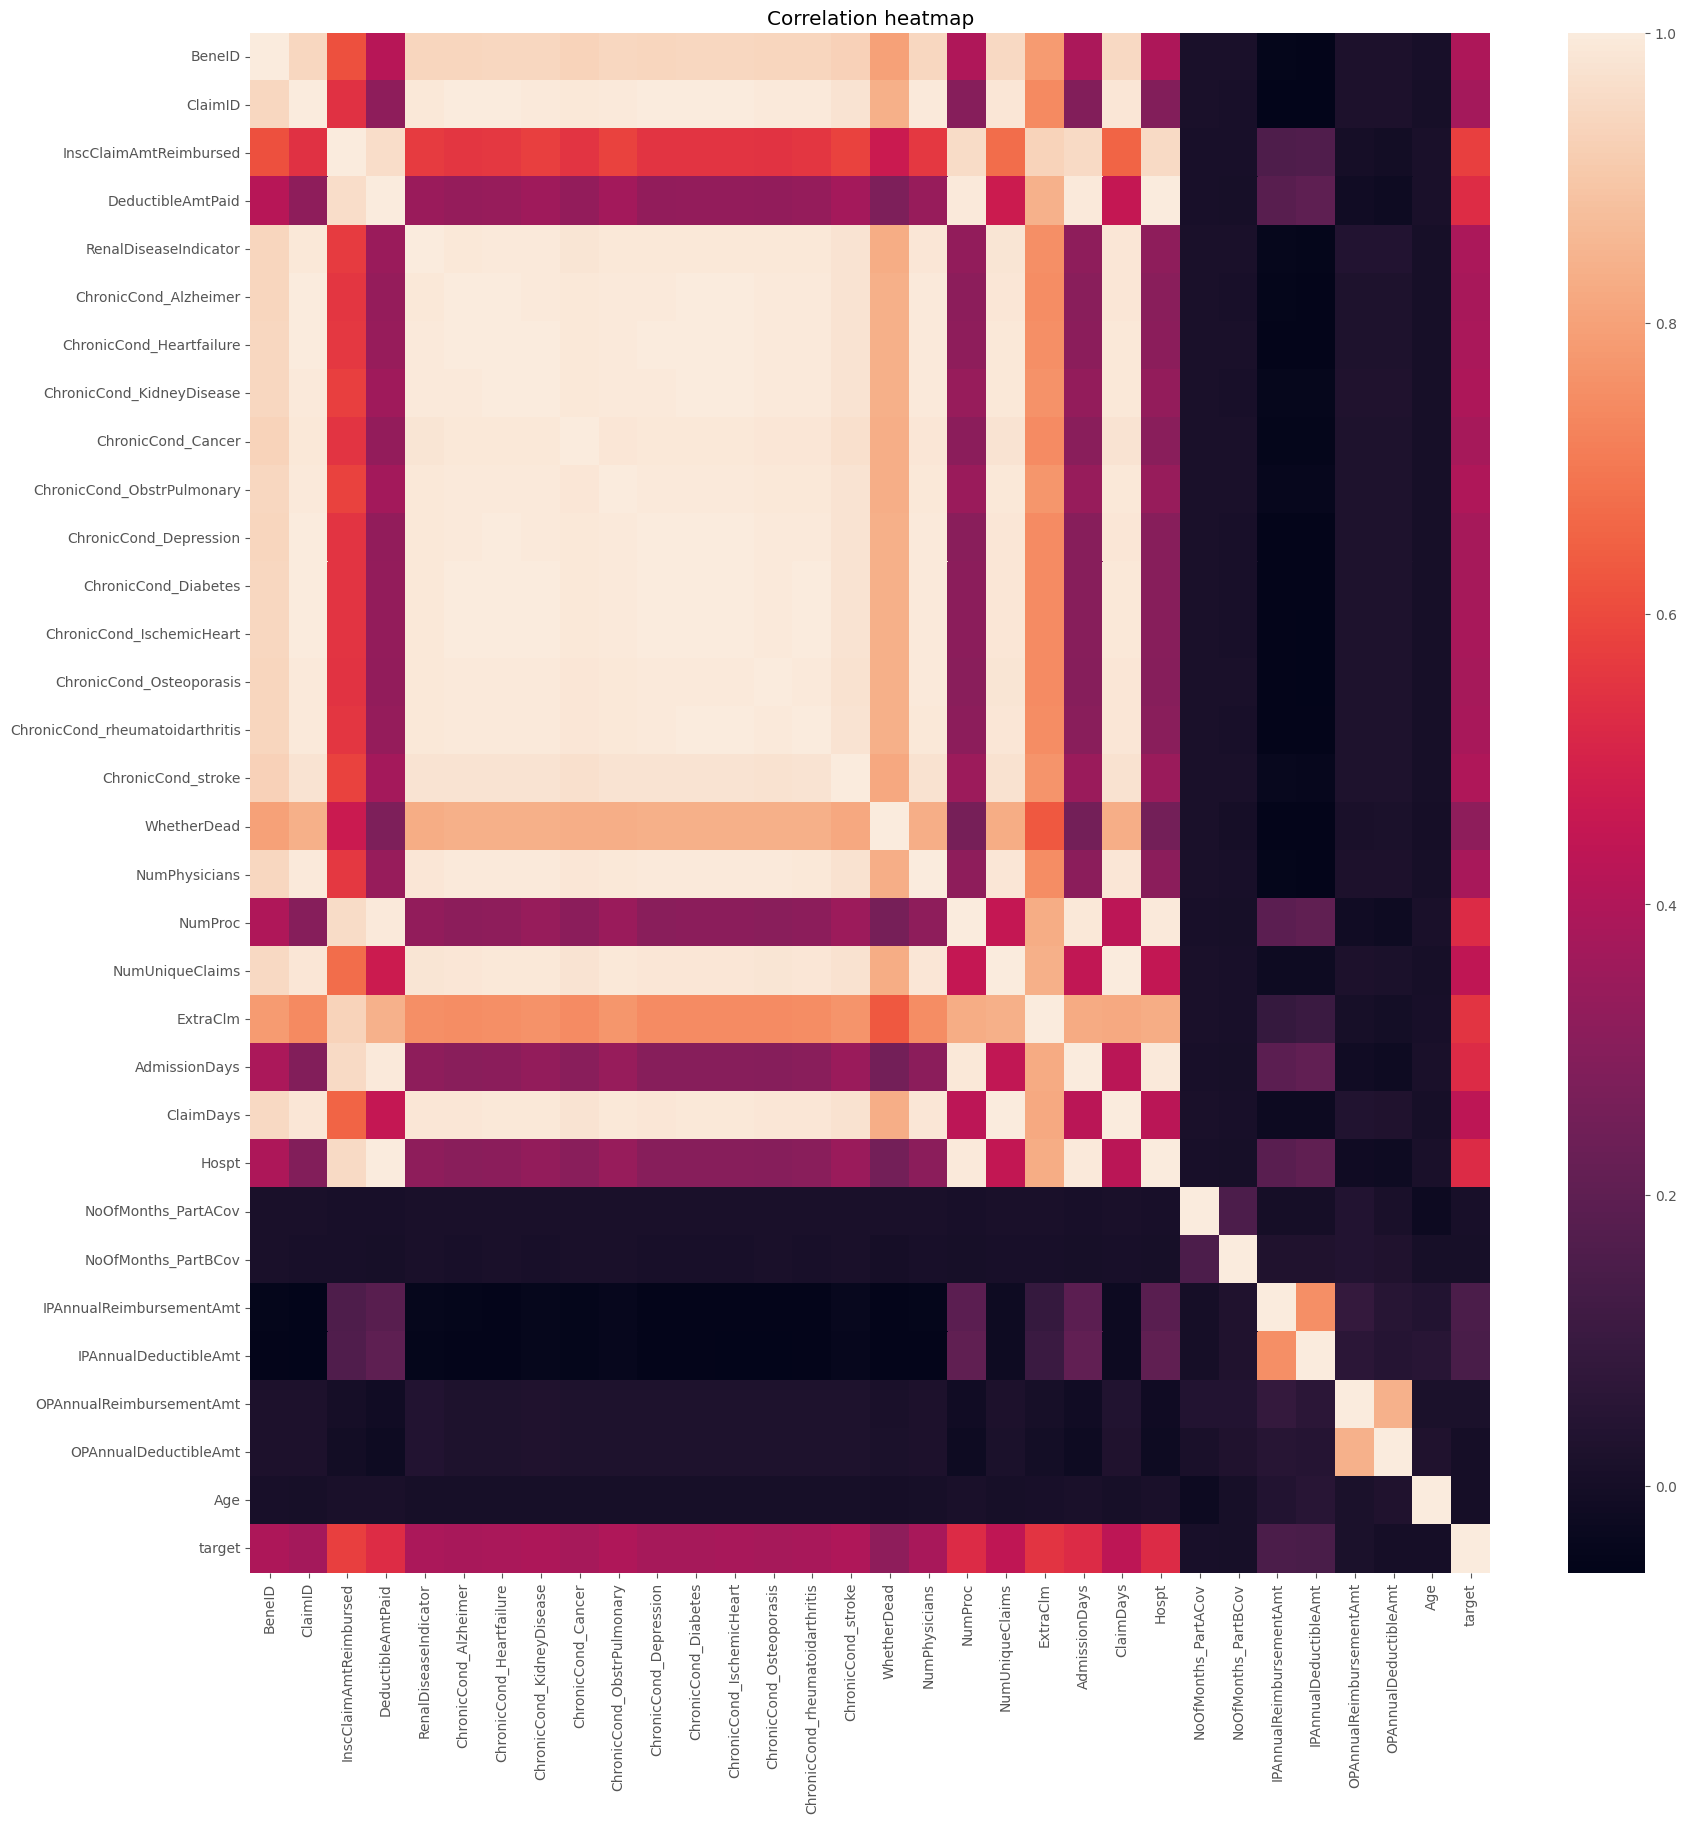

In [38]:
plt.figure(figsize=(20, 20))
plt.title('Correlation heatmap')
sns.heatmap(df2.corr())
plt.show()

In [39]:
countFraud = target.target.value_counts()
print('No:', countFraud[0])
print('Yes:', countFraud[1])
print('Proportion:', round(countFraud[1] / countFraud[0], 2))
### We should keep in mind that we are using unbalanced data

No: 4904
Yes: 506
Proportion: 0.1


## Splitting the data

In [68]:
### Only Train dataset is labeled that why we split it to two sets train and validation
X_train, X_val, y_train, y_val = train_test_split(df.drop(['Provider'], axis = 1), target.target.to_numpy(), test_size=0.25, random_state=1)



In [69]:
X_train

,BeneID,ClaimID,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,...,AdmissionDays,ClaimDays,Hospt,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age
4796,16,17,3760,190.0,3,7,9,9,3,6,...,0.0,17,0,12.000000,12.000000,3431.764706,859.529412,1763.529412,456.470588,76.176471
1986,45,50,14170,150.0,14,20,29,19,9,17,...,0.0,138,0,12.000000,12.000000,5400.000000,576.720000,2020.400000,694.800000,67.640000
1398,49,62,17660,50.0,22,16,36,32,12,18,...,0.0,147,0,12.000000,12.000000,3698.064516,461.806452,2215.322581,599.838710,72.677419
770,77,79,210190,24634.0,14,35,44,29,18,24,...,141.0,286,24,12.000000,12.000000,7674.936709,1049.316456,1866.708861,566.455696,72.329114
4128,13,19,12810,50.0,7,5,9,5,0,6,...,0.0,70,0,12.000000,12.000000,2421.578947,281.052632,2853.157895,1021.578947,68.789474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,270,305,105080,3296.0,51,125,177,123,47,111,...,5.0,732,2,11.960656,11.957377,4809.934426,487.134426,2142.262295,627.639344,73.363934
5192,36,38,7750,100.0,5,15,22,15,7,6,...,0.0,59,0,11.684211,11.842105,2100.526316,281.052632,2638.421053,761.052632,73.815789
3980,17,17,8700,0.0,5,1,7,9,1,2,...,0.0,60,0,12.000000,12.000000,2218.823529,251.294118,3920.000000,1147.647059,70.235294
235,32,52,107540,7636.0,11,23,35,21,7,29,...,32.0,167,7,11.769231,11.230769,8448.846154,1598.384615,1935.384615,493.653846,71.153846


In [75]:
y_pred=[[ 117, 132, 605670, 66286.0, 29, 56, 80, 64, 10, 41, 54,
       100, 112, 33, 38, 12, 1, 156, 48, 761, 10, 382.0, 617, 62,
       11.818181818181818, 11.871212121212121, 7568.181818181818,
       931.4242424242424, 2678.181818181818, 737.1212121212121,
       69.5530303030303]]


In [67]:
cols = X_train.columns

X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)

print("Train obs: {}; Features Number: {}".format(X_train.shape[0], X_train.shape[1]))
print("Validation obs: {};".format(X_val.shape[0]))

array([[-0.443891  , -0.39710173, -0.41858699, ...,  0.1259445 ,
        -0.25796169, -0.46330076],
       [-0.25770448, -0.20978953,  0.05920175, ...,  0.41112648,
         0.47657937,  0.44790846],
       [-0.48822112, -0.42111612, -0.15545373, ..., -0.40890741,
        -0.25881449, -1.10686781],
       ...,
       [-0.31090062, -0.29624132, -0.13484289, ..., -0.62675057,
        -0.36511292,  0.18519369],
       [-0.17791025, -0.20018377, -0.29701418, ..., -0.31102094,
        -0.46179031, -0.37794584],
       [-0.55028329, -0.45473626, -0.42611018, ..., 13.60812037,
        16.08614538,  2.05376148]])

In [76]:
from sklearn.svm import SVC

# Create an instance of the SVC classifier and train it on the training data
clf = SVC()
clf.fit(X_train, y_train)

# Use the trained classifier to predict the target values for X_train
y_train_pred = clf.predict(y_pred)

# Print the predicted target values
print("Predicted target values for X_train:")
print(y_train_pred)


Predicted target values for X_train:
[1]


In [60]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an instance of the SVC classifier
clf = SVC()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the training and validation sets
train_predictions = clf.predict(X_train)
val_predictions = clf.predict(X_val)

# Calculate and print the accuracy of the classifier on the training and validation sets
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))


Training Accuracy: 93.79%
Validation Accuracy: 93.05%


In [43]:
## write Master Learn class which we are going to use for our analysis
class MasterL:
    
    def __init__(self, model, #### model is a method which we are going to use for detecting FRAUDS. For example: sklearn.svm
                 X= X_train, y= y_train, test= X_val, ### data
                 **kvars  #### additional key parameters for model
                ):
        self.clf = model( **kvars)
        self.methodname = model.__name__
        self.X_train = X
        self.y_train = y
        self.X_test = test
        self.fit(self.X_train, self.y_train)
        self.predicted = self.predict(test)
        
    def fit (self, X, y):
        self.clf.fit(X, y)
    
    def predict(self, x):
        return self.clf.predict(x)
       
    def get_score(self, y = y_val, roc = True, params = False):
        accuracy = accuracy_score(self.predicted, y)
        if params:
            print(self.clf.get_params())
        print(self.methodname+ " metrics:\n")
        print(" Accuracy Score: %.2f%%" % (accuracy * 100.0))
        print(" Confusion matrix:", "\n",confusion_matrix(y_true=y, y_pred=self.predicted))
        print( 'Classification report:\n', classification_report(y, self.predicted))
        if roc:
            print(" ROC Score: %.2f%%" % (roc_auc_score(y, self.clf.predict_proba(self.X_test)[:,1])))
        
    def plot_curves(self, y = y_val):   
        plt.figure(figsize=(17, 5))
        plt.subplot(131)
        # Plot the recall precision tradeoff        
        self.plot_pr_curve(y)
        plt.subplot(132)        
        self.plot_lern_curve(accuracy_score)     
        plt.subplot(133)
        self.plot_lern_curve(roc_auc_score)
        plt.show()
        
    def plot_pr_curve(self, y = y_val):
        
        plt.subplot(122)
        # Calculate average precision and the PR curve
        average_precision = average_precision_score(y, self.predicted)

        # Obtain precision and recall 
        precision, recall, _ = precision_recall_curve(y, self.clf.predict_proba(self.X_test)[:,1])
        
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.05])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format( average_precision))
    
    def plot_lern_curve(self, metrics):
        plt.title(self.methodname + " Learning Curves")
        plt.xlabel("Training examples")
        plt.ylabel("{}".format(' '.join(metrics.__name__.split('_')).title()))
        
        train_sizes, train_scores, test_scores = learning_curve(self.clf, self.X_train, self.y_train, n_jobs=-1, 
                                                                cv = ShuffleSplit(n_splits=5, test_size=.25 , random_state = 5), 
                                                                train_sizes=np.linspace(0.5, 1.0, 10), scoring = make_scorer(metrics))
        train_scores_mean = np.mean(train_scores, axis=1) 
        test_scores_mean = np.mean(test_scores, axis=1) 
        #plt.grid()

        plt.plot(train_sizes,  train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes,  test_scores_mean, 'o-', color="g", label="Cross-validation score")
        
        plt.legend(loc="best")
    
    def plot_roc_curve(self, y = y_val, models = None, fig = None):
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_subplot(121)
        
        self.roc_curves(ax, y, models)
        
        ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        
        plt.legend(loc="best")
        
        #if fig != None:
            #plt.savefig( fig, bbox_inches = 'tight')
       
    def roc_curves(self, p, y, M):
        if M == None:
            fpr, tpr, thresholds = roc_curve(y, self.clf.predict_proba(self.X_test)[:,1] )
            p.plot(fpr, tpr,  label=self.methodname )
        else:
            fpr, tpr, thresholds = roc_curve(y, self.clf.predict_proba(self.X_test)[:,1] )
            p.plot(fpr, tpr,  label=self.methodname )
            for i in M:
                fpr, tpr, thresholds = roc_curve(y, i.clf.predict_proba(i.X_test)[:,1] )
                p.plot(fpr, tpr,  label=i.methodname )

#### Function for serching best parameters which is fiting the model and shows best results for specified method.               
def grid(method, parameters):
    
    grid_1 = GridSearchCV(method, parameters, scoring = make_scorer(accuracy_score), cv=5, n_jobs = -1)
    grid_2 = GridSearchCV(method, parameters, scoring = make_scorer(roc_auc_score), cv=5, n_jobs = -1)
    
    grid_1.fit(X_train, y_train)
    print('Best parameters using accuracy score:')
    print(grid_1.best_params_)

    grid_2.fit(X_train, y_train)
    print('Best parameters usin ROC accuracy score:')
    print(grid_2.best_params_)

## 1. Logistic regression

### Grid Seach best Parametes for Log-reg L2 regularization
```pyhon
parameters = { 
        'C' : np.linspace(0.001, 1.0, 1000)
}

grid(LogisticRegression(solver= 'liblinear', class_weight='balanced', random_state = 5), parameters)
```

### Grid Seach best Parametes for Log-reg L1 regularization
```
parameters = { 
        'C' : np.linspace(0.001, 1.0, 1000)
}

grid(LogisticRegression(penalty = 'l1', solver= 'liblinear', class_weight='balanced', random_state = 5), parameters)
```

In [44]:
### Logistic regression 
### Balanced Weight and Scaled data
ML1 = MasterL(LogisticRegression, 
              penalty= 'l1',
              solver= 'liblinear', class_weight='balanced', random_state = 5 , C = 0.001)
# Get your performance metrics
ML1.get_score()

LogisticRegression metrics:

 Accuracy Score: 83.74%
 Confusion matrix: 
 [[1023  210]
 [  10  110]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1233
           1       0.34      0.92      0.50       120

    accuracy                           0.84      1353
   macro avg       0.67      0.87      0.70      1353
weighted avg       0.93      0.84      0.87      1353

 ROC Score: 0.94%


### Plot validation results

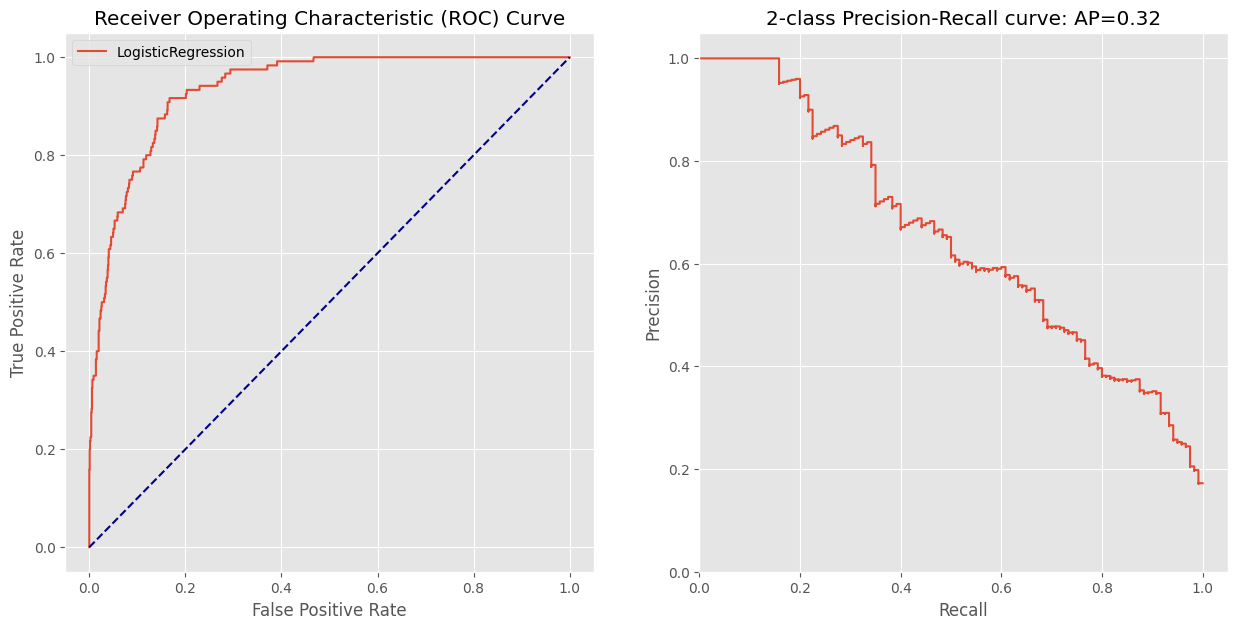

In [45]:
ML1.plot_roc_curve()
ML1.plot_pr_curve()

## 2. Support Vector Machines(SVM)

### Grid Seach best Parametes for SVM
```
parameters = { 
        #'gamma' : np.linspace(0.01, .1, 5),
        'C' : np.linspace(0.1, 1.0, 10)
}

grid(SVC( gamma = 'auto', probability = True, random_state= 5, class_weight= 'balanced'), parameters)
```

In [46]:
# SVM(scaled data)
ML2 = MasterL(SVC, 
              gamma = 'auto', probability = True, random_state= 5, class_weight= 'balanced', C=1 )

# Get your performance metrics
ML2.get_score()

SVC metrics:

 Accuracy Score: 85.07%
 Confusion matrix: 
 [[1046  187]
 [  15  105]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      1233
           1       0.36      0.88      0.51       120

    accuracy                           0.85      1353
   macro avg       0.67      0.86      0.71      1353
weighted avg       0.93      0.85      0.88      1353

 ROC Score: 0.92%


### Plot validation results

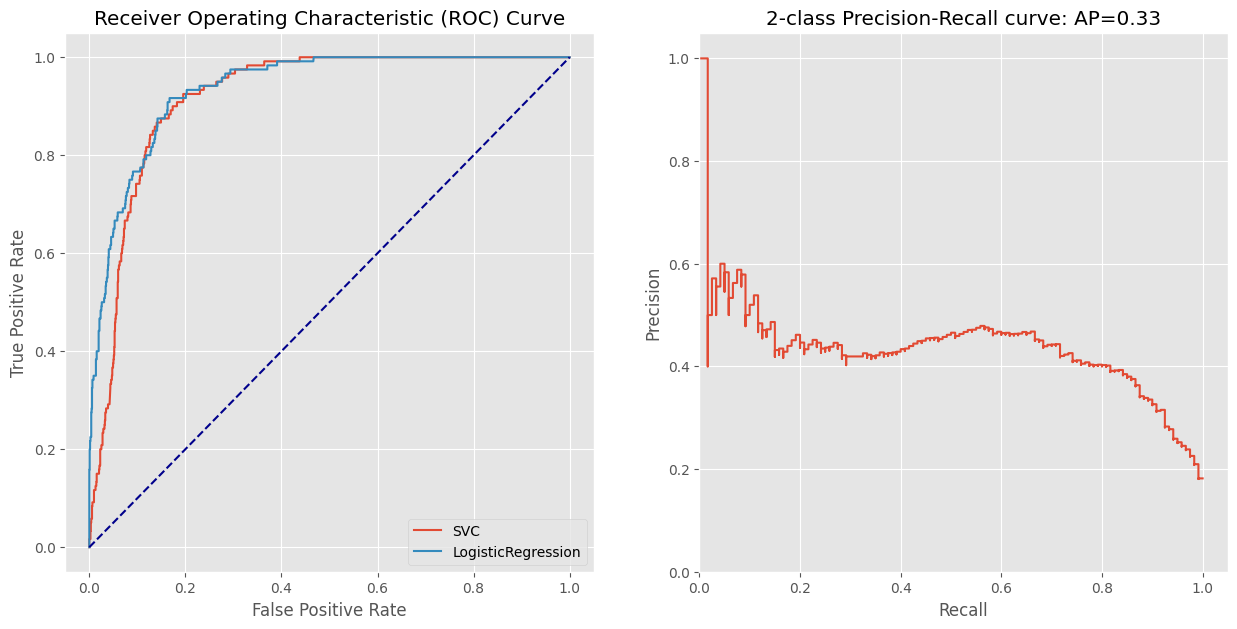

In [47]:
ML2.plot_roc_curve(models = [ML1])
ML2.plot_pr_curve()

## 3. Random Forest Clasifier

### Search best parametes**
```
kf = KFold(n_splits=5)
est = np.linspace(10, 200, 39)

RandFo = dict() 
def kind_GridSearchCV(i):
    acScore = list()
    rocScore = list()    
    for train_index, test_index in kf.split(X_train):
        Xtrain, Xtest = X_train[train_index], X_train[test_index]
        ytrain, ytest = y_train[train_index], y_train[test_index]
        RandFo[i] = RandomForestClassifier(n_estimators =  i, n_jobs = -1, random_state = 5, 
                                           class_weight = 'balanced_subsample', min_samples_split = 0.25 )
        RandFo[i].fit(Xtrain, ytrain)
        acScore.append(accuracy_score(RandFo[i].predict(X_val), y_val))
        rocScore.append(roc_auc_score(y_val, RandFo[i].predict_proba(X_val)[:,1]))
        
    return  [ i, np.mean(acScore), np.mean(rocScore) ]

scores = list()
for i in est:
    scores.append(kind_GridSearchCV(int(i)))

scoresD = pd.DataFrame(scores, columns = ['N_est', 'Accuracy', "ROC accuracy"])

print(scoresD.sort_values(by=['Accuracy'], ascending=False).iloc[0])
print(scoresD.sort_values(by=["ROC accuracy"], ascending=False).iloc[0])
```

In [48]:
### Random Forest Clasifier
# Continue fitting the model and obtain predictions

ML3 = MasterL(RandomForestClassifier, 
              n_estimators = 60, n_jobs = -1, random_state = 5, class_weight = 'balanced_subsample', 
              min_samples_split = 0.25
             )
 
# Get your performance metrics
ML3.get_score() 

RandomForestClassifier metrics:

 Accuracy Score: 78.42%
 Confusion matrix: 
 [[950 283]
 [  9 111]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      1233
           1       0.28      0.93      0.43       120

    accuracy                           0.78      1353
   macro avg       0.64      0.85      0.65      1353
weighted avg       0.93      0.78      0.83      1353

 ROC Score: 0.92%


### Plot validation results

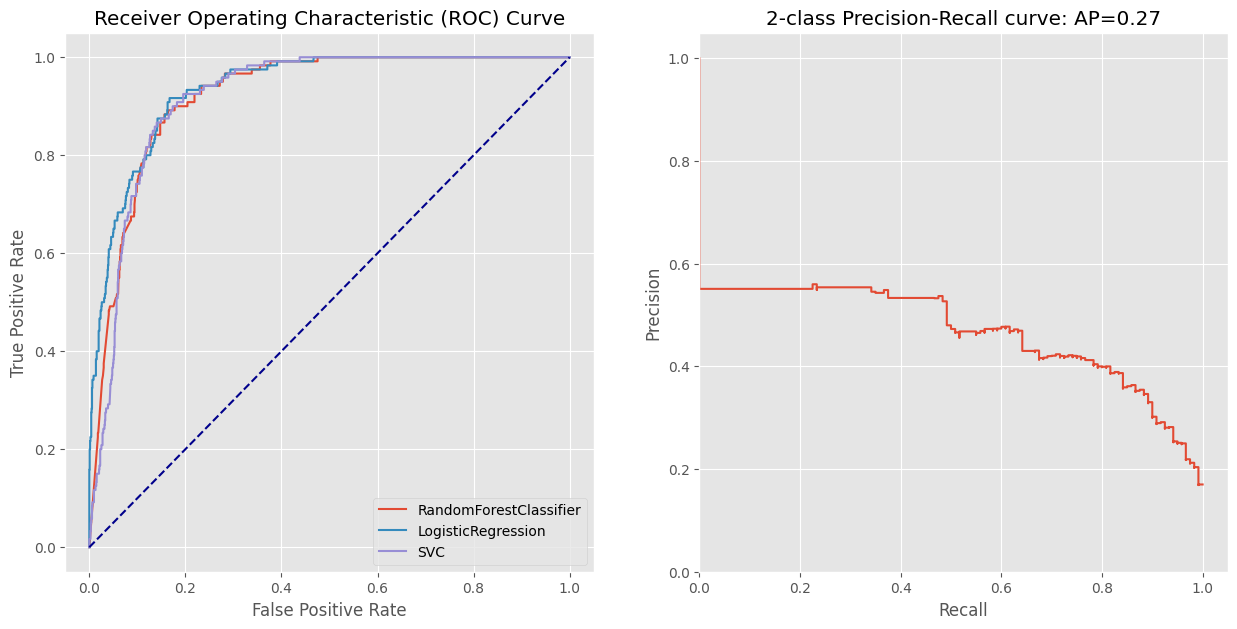

In [49]:
ML3.plot_roc_curve(models = [ML1, ML2])
ML3.plot_pr_curve()

### Top highest scoring Random Forest Features


In [50]:
features = ML3.clf.feature_importances_
Features_score = pd.DataFrame(np.array([cols, features]).T, columns = ["VarName", "Importamce"]).sort_values(by=["Importamce"], ascending=False)

Features_score.head()

,VarName,Importamce
21,AdmissionDays,0.159161
2,InscClaimAmtReimbursed,0.140527
3,DeductibleAmtPaid,0.113984
20,ExtraClm,0.105328
18,NumProc,0.080645


## 4. Ensemble method clasifier (log-reg + Random Forest)

In [51]:
### Generate ensemble
ML4 = MasterL(VotingClassifier, 
              estimators=[ ('lr', ML1.clf), ("rf", ML3.clf)], voting='soft', n_jobs = -1
             )
 
# Get your performance metrics
ML4.get_score()

VotingClassifier metrics:

 Accuracy Score: 78.71%
 Confusion matrix: 
 [[954 279]
 [  9 111]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      1233
           1       0.28      0.93      0.44       120

    accuracy                           0.79      1353
   macro avg       0.64      0.85      0.65      1353
weighted avg       0.93      0.79      0.83      1353

 ROC Score: 0.93%


* ### Plot validation results

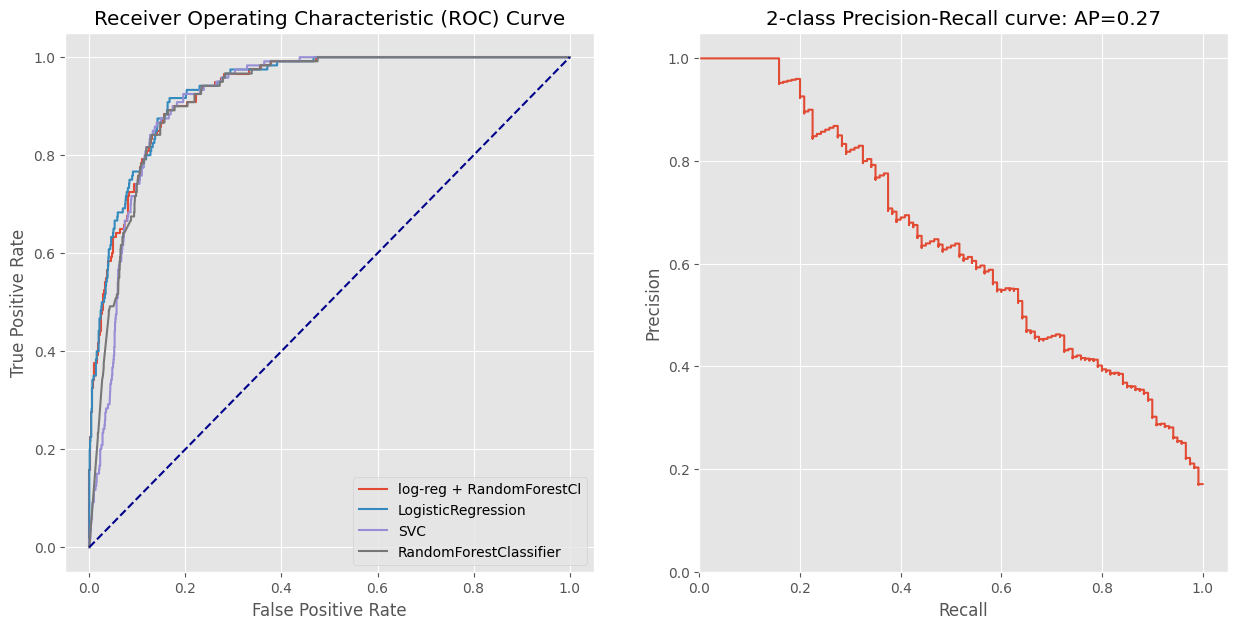

In [52]:
ML4.methodname = "log-reg + RandomForestCl"
ML4.plot_roc_curve(models = [ML1, ML2, ML3])
ML4.plot_pr_curve()

## 5. Multi-layer Perceptron classifier(MLP)

### Grid Seach best Parametes for MLP
```
x = np.array(list(map(int, np.linspace(1, 31, 31))))

parameters = { 
        'hidden_layer_sizes' : list(zip(np.tile(x, len(x)), np.repeat(x, len(x))))
}

grid(MLPClassifier ( activation = 'logistic', random_state = 5, max_iter= 1000), parameters)
```

In [53]:
### Multy Layer Perceptron
ML5 = MasterL( MLPClassifier, 
              activation = 'logistic',
              hidden_layer_sizes = (1, 3),random_state = 5, max_iter= 1000 )
# Get your performance metrics 
ML5.get_score()

MLPClassifier metrics:

 Accuracy Score: 91.65%
 Confusion matrix: 
 [[1158   75]
 [  38   82]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      1233
           1       0.52      0.68      0.59       120

    accuracy                           0.92      1353
   macro avg       0.75      0.81      0.77      1353
weighted avg       0.93      0.92      0.92      1353

 ROC Score: 0.94%


### Plot validation results

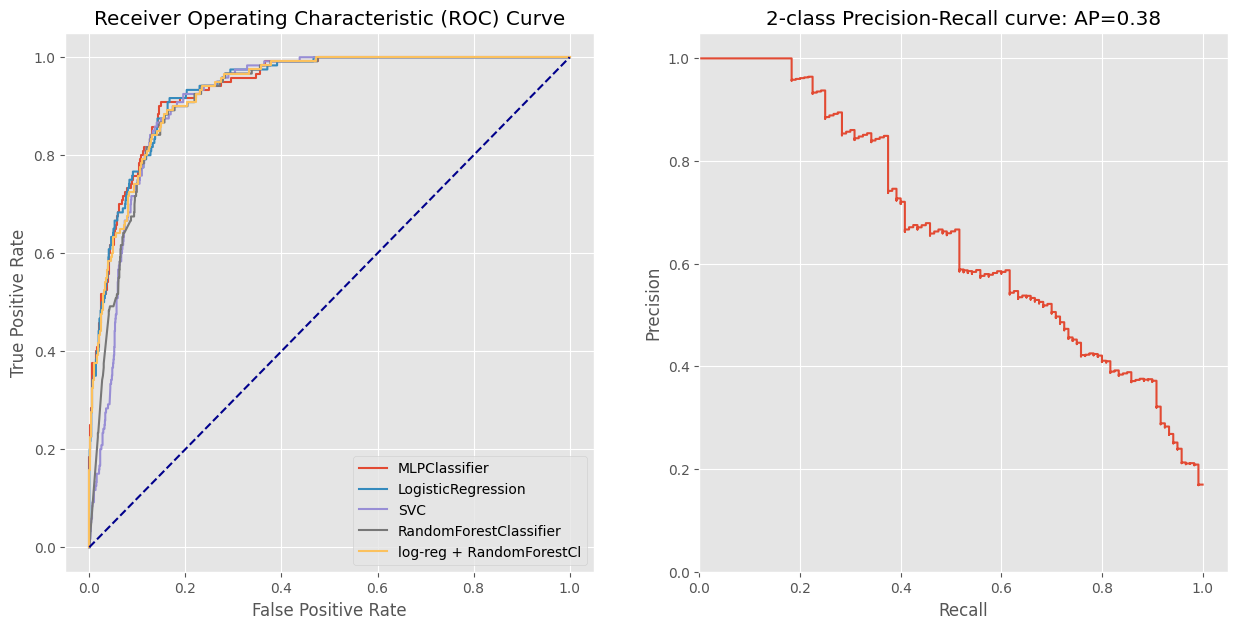

In [54]:
ML5.plot_roc_curve(models = [ML1, ML2, ML3, ML4])
ML5.plot_pr_curve()